In [ ]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os
from scipy import ndimage
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from google.colab import files

class DataLoader:
    def __init__(self, url, extract_path):
        self.url = url
        self.extract_path = extract_path

    def download_and_extract_zip(self):
        """Download and extract the zip file from the provided URL."""
        zip_path = 'arabic_handwritten_digits.zip'
        response = requests.get(self.url)
        with open(zip_path, 'wb') as file:
            file.write(response.content)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(self.extract_path)

    def load_data(self):
        """Load and preprocess the dataset."""
        self.download_and_extract_zip()

        train_images = pd.read_csv(f'{self.extract_path}/arabic_handwritten_digits/csvTrainImages 60k x 784.csv', header=None).values
        train_labels = pd.read_csv(f'{self.extract_path}/arabic_handwritten_digits/csvTrainLabel 60k x 1.csv', header=None).values
        test_images = pd.read_csv(f'{self.extract_path}/arabic_handwritten_digits/csvTestImages 10k x 784.csv', header=None).values
        test_labels = pd.read_csv(f'{self.extract_path}/arabic_handwritten_digits/csvTestLabel 10k x 1.csv', header=None).values

        # Normalize the images
        train_images = train_images / 255.0
        test_images = test_images / 255.0

        # Convert labels to categorical
        train_labels = to_categorical(train_labels, num_classes=10)
        test_labels = to_categorical(test_labels, num_classes=10)

        return (train_images, train_labels), (test_images, test_labels)

    def augment_data(self, images, labels):
        """Augment the dataset by adding inverted images."""
        inverted_images = 1 - images  # Invert the images
        augmented_images = np.vstack((images, inverted_images))
        augmented_labels = np.vstack((labels, labels))
        return augmented_images, augmented_labels

    def show_samples(self, images, labels, num_samples=5):
        """Display a few samples from the dataset."""
        plt.figure(figsize=(10, 2))
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            img = images[i].reshape(28, 28)
            img = ndimage.rotate(img, -90)  # Rotate the image by -90 degrees to fix orientation
            img = np.fliplr(img)  # Flip the image horizontally to correct left-right orientation
            plt.imshow(img, cmap='gray')
            plt.title(np.argmax(labels[i]))
            plt.axis('off')
        plt.show()

class ModelHandler:
    def __init__(self):
        self.model = None

    def build_model(self):
        """Build and compile the neural network model."""
        self.model = Sequential([
            Dense(512, activation='relu', input_shape=(784,)),
            Dropout(0.2),
            Dense(512, activation='relu'),
            Dropout(0.2),
            Dense(10, activation='softmax')
        ])
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def train_model(self, train_data, test_data, epochs=35, batch_size=128):
        """Train the model with the given training data."""
        history = self.model.fit(train_data[0], train_data[1], epochs=epochs, batch_size=batch_size, validation_data=test_data)
        return history

    def save_model(self, file_path):
        """Save the trained model to a file."""
        self.model.save(file_path)

    def load_model(self, file_path):
        """Load a trained model from a file."""
        self.model = load_model(file_path)

class ImagePredictor:
    def __init__(self, model):
        self.model = model

    def predict_digit(self, image_path):
        """Predict the digit from a given image."""
        # Load and preprocess the image
        img = load_img(image_path, color_mode='grayscale', target_size=(28, 28))
        img = ndimage.rotate(img, -90)  # Rotate the image by -90 degrees to fix orientation
        img = np.fliplr(img)  # Flip the image horizontally to correct left-right orientation
        img_array = img_to_array(img).reshape((1, 784))
        img_array = img_array / 255.0

        # Predict the class
        prediction = self.model.predict(img_array)
        return np.argmax(prediction)

    def display_image(self, image_path):
        """Display the image using matplotlib."""
        img = load_img(image_path, color_mode='grayscale', target_size=(28, 28))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()

In [ ]:
# Define paths and URLs
dataset_url = 'https://github.com/ridwaanhall/datasets/raw/main/arabic_handwritten_digits.zip'
extract_path = './data'



In [ ]:
# Load and preprocess data
data_loader = DataLoader(dataset_url, extract_path)
(train_images, train_labels), (test_images, test_labels) = data_loader.load_data()


In [ ]:

# Augment the data by adding inverted images
train_images, train_labels = data_loader.augment_data(train_images, train_labels)
test_images, test_labels = data_loader.augment_data(test_images, test_labels)



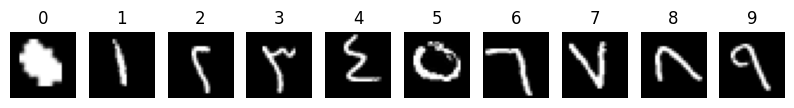

In [ ]:
# Show some sample images from the training dataset
data_loader.show_samples(images=train_images, labels=train_labels, num_samples=10)


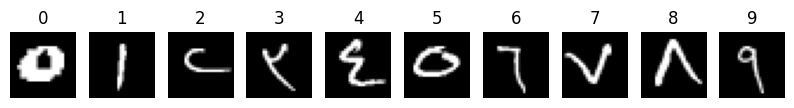

In [ ]:
data_loader.show_samples(images=test_images, labels=test_labels, num_samples=10)


In [ ]:
# Build, train, and save the model
model_handler = ModelHandler()
model_handler.build_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 669706 (2.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# model_handler.train_model((train_images, train_labels), (test_images, test_labels))
history = model_handler.train_model((train_images, train_labels), (test_images, test_labels))
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_history.csv', index=False)

Epoch 1/35
938/938 [==============================] - 8s 5ms/step - loss: 0.2672 - accuracy: 0.9204 - val_loss: 0.1253 - val_accuracy: 0.9624
Epoch 2/35
938/938 [==============================] - 4s 4ms/step - loss: 0.1254 - accuracy: 0.9624 - val_loss: 0.1280 - val_accuracy: 0.9618
Epoch 3/35
938/938 [==============================] - 4s 4ms/step - loss: 0.1088 - accuracy: 0.9673 - val_loss: 0.1066 - val_accuracy: 0.9679
Epoch 4/35
938/938 [==============================] - 4s 5ms/step - loss: 0.0963 - accuracy: 0.9705 - val_loss: 0.1004 - val_accuracy: 0.9710
Epoch 5/35
938/938 [==============================] - 5s 5ms/step - loss: 0.0899 - accuracy: 0.9726 - val_loss: 0.1147 - val_accuracy: 0.9679
Epoch 6/35
938/938 [==============================] - 6s 6ms/step - loss: 0.0835 - accuracy: 0.9748 - val_loss: 0.1008 - val_accuracy: 0.9711
Epoch 7/35
938/938 [==============================] - 4s 4ms/step - loss: 0.0867 - accuracy: 0.9735 - val_loss: 0.0925 - val_accuracy: 0.9747
Epoch 

In [ ]:
model_handler.save_model('arabic_handwritten_digit_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

# Load the model and predict new images
model_handler.load_model('arabic_handwritten_digit_model.h5')
image_predictor = ImagePredictor(model_handler.model)



Saving Screenshot 2024-06-19 152131.png to Screenshot 2024-06-19 152131.png


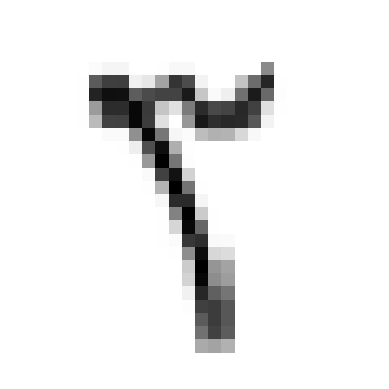

1/1 [==============================] - 0s 123ms/step
The predicted digit for Screenshot 2024-06-19 152131.png is 3


In [ ]:
uploaded_image = files.upload()

for fn in uploaded_image.keys():
  image_predictor.display_image(fn)
  prediction = image_predictor.predict_digit(fn)
  print(f'The predicted digit for {fn} is {prediction}')